# Higher order functions

Not to be confused with higher order derivatives.

[Higher order functions](https://en.wikipedia.org/wiki/Higher-order_function) are functions which return a function.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Simple Example of a curried function

[StackOverflow Example](https://stackoverflow.com/questions/36314/what-is-currying)

We take two variables $x1$ and $x2$ and multiply them together. We can see that tensorflow is able to compute the gradient with respect both these variables.

Note: Tensorflow 2.1.0 does not support `@tf.function` for functions that do not return a tensor. This may change in future. So, the outer function is executed eagerly, while the inner function is in graph mode.

In [4]:
def curried_generator(x1):
    @tf.function
    def inner(x2):
        return x1 * x2
    return inner

In [5]:
x1 = tf.Variable([2,2,2], dtype=tf.float32)
x2 = tf.Variable([1,2,3], dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    eqn = curried_generator(x1)
    z = eqn(x2)
    
print(eqn)
print(tape.gradient(z, x1))
print(tape.gradient(z, x2))

tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32)
tf.Tensor([2. 2. 2.], shape=(3,), dtype=float32)


## Polynomial Regression

Below is an example of a generator function, which takes a function definition as an argument and returns a function which has the same tensorflow graph as the polynomial. 

The equation is encoded as follows

$$
equation = 4x^2 + 3x ^ 3 + 2x ^ 5
$$

\begin{equation*}
definition = 
\begin{bmatrix}
constant & exponent \\
4.0 & 2.0 \\
3.0 & 3.0 \\
2.0 & 5.0 \\
\end{bmatrix}
\end{equation*}

In [6]:
def polynomial_generator(definition):
    definition = tf.unstack(definition)
    
    @tf.function
    def inner(x):
        result = 0.0
        for term in definition:
            constant = term[0]
            exponent = term[1]
            result += constant * tf.pow(x, exponent)
        return result
    return inner

In [7]:
definition = tf.Variable([
    [2.0, 1.0],
    [3.0, 2.0],
    [1.0, 4.0]
], dtype=tf.float32) # 2 * x + 3 * x ^ 2 + 1 * x ^ 4
x = tf.Variable([1,2,3], dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    eqn = polynomial_generator(definition)
    z = eqn(x)
    
print(tape.gradient(z, x))
print(tape.gradient(z, definition))

tf.Tensor([ 12.  46. 128.], shape=(3,), dtype=float32)
tf.Tensor(
[[  6.         9.364263]
 [ 14.        37.9803  ]
 [ 98.       100.07795 ]], shape=(3, 2), dtype=float32)


In [8]:
def pretty_print_definition(definition):
    definition = tf.unstack(definition)
    result = ''
    template = "{} {:.2f} * x ^ {:.2f} "
    for term in definition:
        constant = np.round(term[0].numpy(), 2)
        exponent = np.round(term[1].numpy(), 2)
        sign_separator = '+' if constant >= 0 else ''
        result += template.format(sign_separator, constant, exponent)
    return result
tf.print(definition)
pretty_print_definition(definition)

[[2 1]
 [3 2]
 [1 4]]


'+ 2.00 * x ^ 1.00 + 3.00 * x ^ 2.00 + 1.00 * x ^ 4.00 '

### Generating data

To illustrate that the model can learn to fit a polynomial, we generate data for ground truth.

We sample $100$ points uniformly between $0.0$ and $1.5$ for the equation below.

$$
equation = 2x - 3x ^ 2 + x ^ 4
$$

In [9]:
definition = tf.Variable([
    [2.0, 1.0],
    [-3.0, 2.0],
    [1.0, 4.0]
], dtype=tf.float32) # 2 * x - 3 * x ^ 2 + 1 * x ^ 4
original_definition = definition # Take a backup
pretty_print_definition(definition)

'+ 2.00 * x ^ 1.00  -3.00 * x ^ 2.00 + 1.00 * x ^ 4.00 '

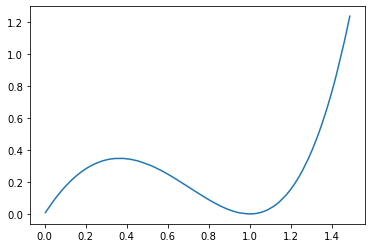

In [10]:
eqn = polynomial_generator(definition)
xs = tf.random.uniform((100,), dtype=tf.float32) * 1.5
ys = eqn(xs)

s_xs = tf.sort(xs)
s_ys = eqn(s_xs)
plt.plot(s_xs, s_ys)
plt.show()

### Training

For training, we initialize a new function definition with uniform random variables.

The loss is the L2 loss between the predicted $y$ and the ground truth $y$

In [11]:
opt = tf.keras.optimizers.Adam()

definition = tf.Variable(tf.random.uniform((3, 2)), dtype=tf.float32)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        eqn = polynomial_generator(definition) # Generate a new equation with updated definition
        ys_ = eqn(xs) # Predict new y
        loss = tf.nn.l2_loss(ys - ys_) # Find loss
    grads = tape.gradient(loss, definition)
    opt.apply_gradients(zip([grads], [definition])) # Update the polynomial definition
    return loss

In [12]:
for i in range(10000):
    loss = train_step()
    if i % 1000 == 0:
        equation_deviation = tf.nn.l2_loss(definition - original_definition)
        tf.print(loss, equation_deviation)

43.2280502 12.9161654
2.83604884 12.8302612
2.55241275 10.8775578
1.73262882 7.27807283
0.860218048 5.23413849
0.269716203 4.44122219
0.0641011596 4.31855488
0.0329511911 4.08917236
0.0242073368 3.71410298
0.0187329985 3.36848712


### Results

The generated equation varies between runs but it resembles the ground truth equation, closely.

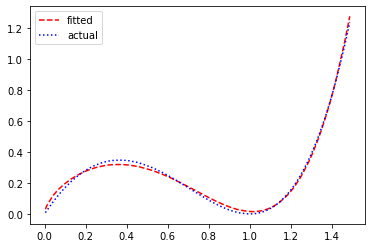

In [13]:
eqn = polynomial_generator(definition)
ns_ys = eqn(s_xs)
plt.plot(s_xs, ns_ys, color='red',linestyle='--', label='fitted')
plt.plot(s_xs, s_ys, color='blue',linestyle='dotted', label='actual')
plt.legend()
plt.show()

In [14]:
print(pretty_print_definition(original_definition))
print(pretty_print_definition(definition))

+ 2.00 * x ^ 1.00  -3.00 * x ^ 2.00 + 1.00 * x ^ 4.00 
+ 0.80 * x ^ 0.60  -1.25 * x ^ 2.30 + 0.46 * x ^ 5.00 
